# Company Discourse

### 1. Dependencies (i.e., libraries we use)

In [2]:
import praw # https://praw.readthedocs.io/ -- PRAW for scraping Reddit comments
from praw.models import MoreComments

from sentence_transformers import SentenceTransformer # https://sbert.net/ -- SBERT for sentence comparison

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score # it is advised to use precision instead of accuracy when the data is too biased

from tqdm import tqdm, tqdm_notebook # https://tqdm.github.io/ -- measures runtime of loops
from datetime import datetime # https://docs.python.org/3/library/datetime.html -- to manipulate time units
import os.path # https://docs.python.org/3/library/os.path.html -- this lets us tell whether to load or create/save dataframe

from credentials import reddit_credential

### 2. Functions for Scraping Reddit Comments

In [2]:
# Reddit account info to use PRAW
# We should find some way to hide this part of the code eventually (quasi-personal info)
reddit = praw.Reddit(
    client_id = reddit_credential["client_id"],
    client_secret = reddit_credential["client_secret"],
    password = reddit_credential["password"],
    user_agent = reddit_credential["user_agent"],
    username = reddit_credential["username"],
)

reddit.read_only = True # we are only going to read data, so let's keep it this way

In [3]:
# submission.comments consists of one of the following objects
# Comment
# MoreComments -- which may contain Comment objects or MoreComment objects
# The following function break all MoreComments objects into Comment objects

def break_into_comments(submission):
    comment_like_objects = list(submission.comments)
    folded_comments = []
    saved_comments = []
     # list() -- only needed to make it more concrete when we check the code
    while comment_like_objects: # loop continues until comment_like_objects become empty
        for comment in comment_like_objects:
            if (isinstance(comment, MoreComments)):
                folded_comments.append(comment)
            else:
                saved_comments.append(comment)
        comment_like_objects = folded_comments # updating comment_like_objects
        folded_comments = []

    return saved_comments

In [4]:
# input: either submission or comment
# output: time of the submission in local time as datetime object

def time_of(submission):
    ts = submission.created_utc # time given in unix timestamp
    time = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') # This changes unix timestamp into local time
    time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S') # This changes into string datetime object

    return time

In [5]:
# input: subreddit
# output: comments from hot N submissions
# within within [time_1, time_2] if time_1 and time_2 are typed in
# time_1, time_2 are strings of the form '2024-05-09 23:10:02'
# time_1 and time_2 only seem to work if it is within the day of the current time

def extract_comments(subreddit, N, time_1=None, time_2=None):
    saved_comments = []

    if time_1 and time_2:
        time_1 = datetime.strptime(time_1, '%Y-%m-%d %H:%M:%S')
        time_2 = datetime.strptime(time_2, '%Y-%m-%d %H:%M:%S')

        for submission in tqdm(subreddit.hot(limit=N)):
            if time_1 <= time_of(submission) and time_of(submission) <= time_2:
                saved_comments += break_into_comments(submission)
    else:
        for submission in subreddit.hot(limit=N):
            saved_comments += break_into_comments(submission)

    return saved_comments

### 3. Functions for Vectorizing Comments

In [6]:
# Defining SBERT model for generating sentence embeddings
sentence_model = SentenceTransformer('all-mpnet-base-v2')

# function that vectorizes a sentence
def get_sentence_embedding(text):
    if not text.strip():
    #.strip() gets rid of new lines
        print("Attempted to get embedding for empty text.")
        return []

    embedding = sentence_model.encode(text)

    return embedding.tolist()

In [7]:
# input: Reddit comments
# output: vectors in 1024-dim space corresponding to comments

def comment_embeddings(comments):
    embeddings = list(tqdm(map(get_sentence_embedding, [comment.body for comment in comments])))
    return embeddings

### 4. Constructing and Saving/Loading Data Frames

In [8]:
tqdm.pandas() # This would measure how much time we take whenever we use pd

In [9]:
# The following generates df from comments
# We need to add column for vectors later because generating them together takes forever

def comments_into_df(comments):
    dic = {
            'Author' : [comment.author for comment in comments],
            'Time (PDT)' : [time_of(comment) for comment in comments],
            'Comment' : [comment.body for comment in comments],
            'Vectors' : comment_embeddings(comments),
            'File': comments
            }

    return pd.DataFrame(dic)

In [10]:
# input: subreddit
# output: dataframe from hot N submissions
# within [time_1, time_2] if they are typed in
# time_1, time_2 are strings of the form '2024-05-09 23:10:02'

def extract_df(subreddit, N, time_1=None, time_2=None):
    return comments_into_df(extract_comments(subreddit, N, time_1, time_2))

In [11]:
# input: subreddit_name (string)
# execution: creates (and stores) or loads dataframes from hot N submissions of the given subreddit
# within [time_1, time_2] if they are typed in
# output: data_frame
# time_1, time_2 are strings of the form '2024-05-09 23:10:02'
# the name of the saved file: df_subreddit_name.csv

def load_or_save_df(subreddit_name, N, time_1=None, time_2=None):

    dataframe_name = 'df_' + subreddit_name + '.csv'
    path = os.path.join('.', 'csvs', dataframe_name)

    if os.path.exists(path): # if the file already exits in the directory, we just load it
        df = pd.read_csv(path , converters={'Vectors': pd.eval})
        # converters -- needed because otherwise vectors are loaded as str

        df = df.drop(columns="Unnamed: 0") # drop unwanted column that comes from read_csv
    else:
        subreddit = reddit.subreddit(subreddit_name)
        df = extract_df(subreddit, N, time_1, time_2)
        df.to_csv(path) # save dataframe

    return df

In [ ]:
# it seems to get a lot slower when as either time_2 - time_1 or N gets larger

df_costco = load_or_save_df("Costco", 50)
df_mcdonalds = load_or_save_df("McDonalds", 50)
df_samsung = load_or_save_df("samsung", 50)
df_open_ai = load_or_save_df("OpenAI", 50)

# df_microsoft = load_or_save_df("microsoft", N) -- Didn't stop for some reason
# df_apple = load_or_save_df("apple", 50) -- Didn't stop for some reason

In [ ]:
df_costco

In [ ]:
df_mcdonalds

In [ ]:
df_samsung

In [ ]:
df_open_ai

### 5. Creating Features of Comments

In [ ]:
# function to compare (sentence) vectors
# inputs v, w are vectors in list object forms
# output can be between -1 and 1, where 1 means the best
# for sentence vectors, output seems to be always between 0 and 1

def cos_angle(v, w):
    v = np.array(v)
    w = np.array(w)
    v = v.reshape(1,-1)
    w = w.reshape(1,-1)
    return cosine_similarity(v, w)[0][0]

In [ ]:
def insert_feature(df, feature_query, feature_name):
    vectors = df.Vectors
    query_vector = get_sentence_embedding(feature_query)

    cos_angles = map(lambda v: cos_angle(v, query_vector), vectors)
    df[feature_name] = pd.DataFrame(cos_angles)

    return df


In [ ]:
df = insert_feature(df_costco, "The quality was very good.", "Quality")
df

In [ ]:
df = insert_feature(df, "The price is very reasonable.", "Price")
df

In [ ]:
df = insert_feature(df_costco, "The quality was horrible.", "Quality (negative)")
df

In [ ]:
df = insert_feature(df, "The price is exorbitant.", "Price (negative)")
df

### 6. Some Demonstrations of Data Frames

First, we consider Price vs. Price (negative) features:

In [ ]:
# top 5 price

df.sort_values(by='Price', ascending = False).head()

In [ ]:
# bottom 5 price

df.sort_values(by='Price', ascending = False).tail()

In [ ]:
# top 5 price (negative)

df.sort_values(by='Price (negative)', ascending = False).head()

In [ ]:
# bottom 5 price (negative)

df.sort_values(by='Price (negative)', ascending = False).tail()

Now, we consider Quality vs. Quality (negative) features:

In [ ]:
df.sort_values(by='Quality', ascending = False).head()

In [ ]:
df.sort_values(by='Quality', ascending = False).tail()

In [ ]:
df.sort_values(by='Quality (negative)', ascending = False).head()

In [ ]:
df.sort_values(by='Quality (negative)', ascending = False).tail()

**Remark**. It does NOT seem that each feature and its negative version has high magnitute correlation (either positive or negative).

In [ ]:
df[['Price','Price (negative)']].corr()

In [ ]:
df[['Quality','Quality (negative)']].corr()

**Remark**. From the pairplot below, it seems that negative questions may be better in creating features.

In [ ]:
sns.pairplot(df)
plt.show()

### 7. Loading Data from SQL DB

In [7]:
import mysql
from sqlalchemy import create_engine
from credentials import mysql_credential

In [10]:
engine = create_engine('mysql+mysqlconnector://{0}:{1}@{2}:{3}/{4}'.
                                               format(mysql_credential['user'],
                                                      mysql_credential['password'], 
                                                      mysql_credential['host'],
                                                      mysql_credential['port'],
                                                      mysql_credential['database']))

connection = mysql.connector.connect(
    user = mysql_credential['user'],
    host = mysql_credential['host'],
    password = mysql_credential['password'],
    database = mysql_credential['database']
)
db_cursor = connection.cursor()

In [12]:
db_cursor.execute('SELECT * FROM costco_0')
df = pd.DataFrame(db_cursor.fetchall())

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,0x88626b6a29df9fb1:0x868c85d23dc91564,0.687718,0.755072,0.703993,0.772153,0.785639,0.837470
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,0x88626b6a29df9fb1:0x868c85d23dc91564,0.745400,0.758608,0.756222,0.799146,0.748689,0.761361
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",0x888922182c25426d:0xabf1b10efa159b19,0.780742,0.743472,0.778489,0.756166,0.820729,0.795782
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",0x888922182c25426d:0xabf1b10efa159b19,0.717102,0.744280,0.721137,0.750801,0.777689,0.798689
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,0x888922182c25426d:0xabf1b10efa159b19,0.702663,0.738231,0.733328,0.786977,0.742539,0.797808
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,100455341287292322242,Vjuana Cordova,1527454390479,5,Busy,0x872b3fa32c779011:0xbb9517890b1815aa,0.747479,0.763667,0.767604,0.753965,0.744185,0.765050
49996,110357544548952104516,Richard Montesano,1539409311700,5,FIRST CLASS,0x872b3fa32c779011:0xbb9517890b1815aa,0.733420,0.771344,0.725295,0.774231,0.782612,0.806080
49997,109917254088777437103,Javy So,1543787088875,5,Good stuff,0x872b3fa32c779011:0xbb9517890b1815aa,0.747810,0.738968,0.781801,0.706057,0.760763,0.746200
49998,105113330396455852844,Sandy Urpman,1527046633908,5,Great place,0x872b3fa32c779011:0xbb9517890b1815aa,0.725769,0.773750,0.716427,0.790583,0.732308,0.782463


In [14]:
columns = db_cursor.description 
columns

[('user_id', 252, None, None, None, None, 1, 16),
 ('name', 252, None, None, None, None, 1, 16),
 ('time', 252, None, None, None, None, 1, 16),
 ('rating', 8, None, None, None, None, 1, 0),
 ('text', 252, None, None, None, None, 1, 16),
 ('gmap_id', 252, None, None, None, None, 1, 16),
 ('quality_neg', 5, None, None, None, None, 1, 0),
 ('quality_pos', 5, None, None, None, None, 1, 0),
 ('price_neg', 5, None, None, None, None, 1, 0),
 ('price_pos', 5, None, None, None, None, 1, 0),
 ('service_neg', 5, None, None, None, None, 1, 0),
 ('service_pos', 5, None, None, None, None, 1, 0)]

In [15]:
columns = [v[0] for v in columns]

In [16]:
columns

['user_id',
 'name',
 'time',
 'rating',
 'text',
 'gmap_id',
 'quality_neg',
 'quality_pos',
 'price_neg',
 'price_pos',
 'service_neg',
 'service_pos']

In [17]:
for i in range(1, 16):
   db_cursor.execute(f'SELECT * FROM costco_{i}')
   df1 = pd.DataFrame(db_cursor.fetchall())
   df = pd.concat([df, df1]) 

In [18]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,0x88626b6a29df9fb1:0x868c85d23dc91564,0.687718,0.755072,0.703993,0.772153,0.785639,0.837470
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,0x88626b6a29df9fb1:0x868c85d23dc91564,0.745400,0.758608,0.756222,0.799146,0.748689,0.761361
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",0x888922182c25426d:0xabf1b10efa159b19,0.780742,0.743472,0.778489,0.756166,0.820729,0.795782
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",0x888922182c25426d:0xabf1b10efa159b19,0.717102,0.744280,0.721137,0.750801,0.777689,0.798689
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,0x888922182c25426d:0xabf1b10efa159b19,0.702663,0.738231,0.733328,0.786977,0.742539,0.797808
...,...,...,...,...,...,...,...,...,...,...,...,...
25648,104746228785609175483,Yingying Zhang,1619146656029,5,Great selection and customer service. Could be...,0x54905cdd231b622d:0xb79711e2eb94eec0,0.693493,0.753508,0.685548,0.740355,0.730651,0.789048
25649,111270653702987963264,Ruth K,1619085522417,5,Good,0x54905cdd231b622d:0xb79711e2eb94eec0,0.754578,0.734638,0.773723,0.727843,0.840403,0.802679
25650,113188879180542932657,abdulwali abdilla,1619040401672,5,Is good so far,0x54905cdd231b622d:0xb79711e2eb94eec0,0.685245,0.746943,0.692085,0.790040,0.747275,0.809937
25651,112485072395000926668,Sanjiv Diwan,1619121010608,2,Overcrowded no parking,0x54905cdd231b622d:0xb79711e2eb94eec0,0.712144,0.786509,0.719176,0.775977,0.747277,0.805125


In [19]:
df.columns = columns
df
    

,user_id,name,time,rating,text,gmap_id,quality_neg,quality_pos,price_neg,price_pos,service_neg,service_pos
0,108341711662008461816,Rod Powell,1580509229183,5,Great service. Nice folks. Very helpful.,0x88626b6a29df9fb1:0x868c85d23dc91564,0.687718,0.755072,0.703993,0.772153,0.785639,0.837470
1,100886664024661856987,zach smithson,1489608374532,5,Amazing how much cheaper their hearing aids ar...,0x88626b6a29df9fb1:0x868c85d23dc91564,0.745400,0.758608,0.756222,0.799146,0.748689,0.761361
2,104116808865576923879,George “Stovie” Moore,1623169525640,1,"I find Hoover, Alabama Costco’s tire service t...",0x888922182c25426d:0xabf1b10efa159b19,0.780742,0.743472,0.778489,0.756166,0.820729,0.795782
3,113636820761208623071,Erica Disbrow,1613357729329,5,"Lambert was so nice, professional, and caring!...",0x888922182c25426d:0xabf1b10efa159b19,0.717102,0.744280,0.721137,0.750801,0.777689,0.798689
4,101232786196219574483,Roy Martin,1613138521284,5,I needed new tires and Costco's price was $400...,0x888922182c25426d:0xabf1b10efa159b19,0.702663,0.738231,0.733328,0.786977,0.742539,0.797808
...,...,...,...,...,...,...,...,...,...,...,...,...
25648,104746228785609175483,Yingying Zhang,1619146656029,5,Great selection and customer service. Could be...,0x54905cdd231b622d:0xb79711e2eb94eec0,0.693493,0.753508,0.685548,0.740355,0.730651,0.789048
25649,111270653702987963264,Ruth K,1619085522417,5,Good,0x54905cdd231b622d:0xb79711e2eb94eec0,0.754578,0.734638,0.773723,0.727843,0.840403,0.802679
25650,113188879180542932657,abdulwali abdilla,1619040401672,5,Is good so far,0x54905cdd231b622d:0xb79711e2eb94eec0,0.685245,0.746943,0.692085,0.790040,0.747275,0.809937
25651,112485072395000926668,Sanjiv Diwan,1619121010608,2,Overcrowded no parking,0x54905cdd231b622d:0xb79711e2eb94eec0,0.712144,0.786509,0.719176,0.775977,0.747277,0.805125


In [20]:
df_train = df.iloc[:10000]

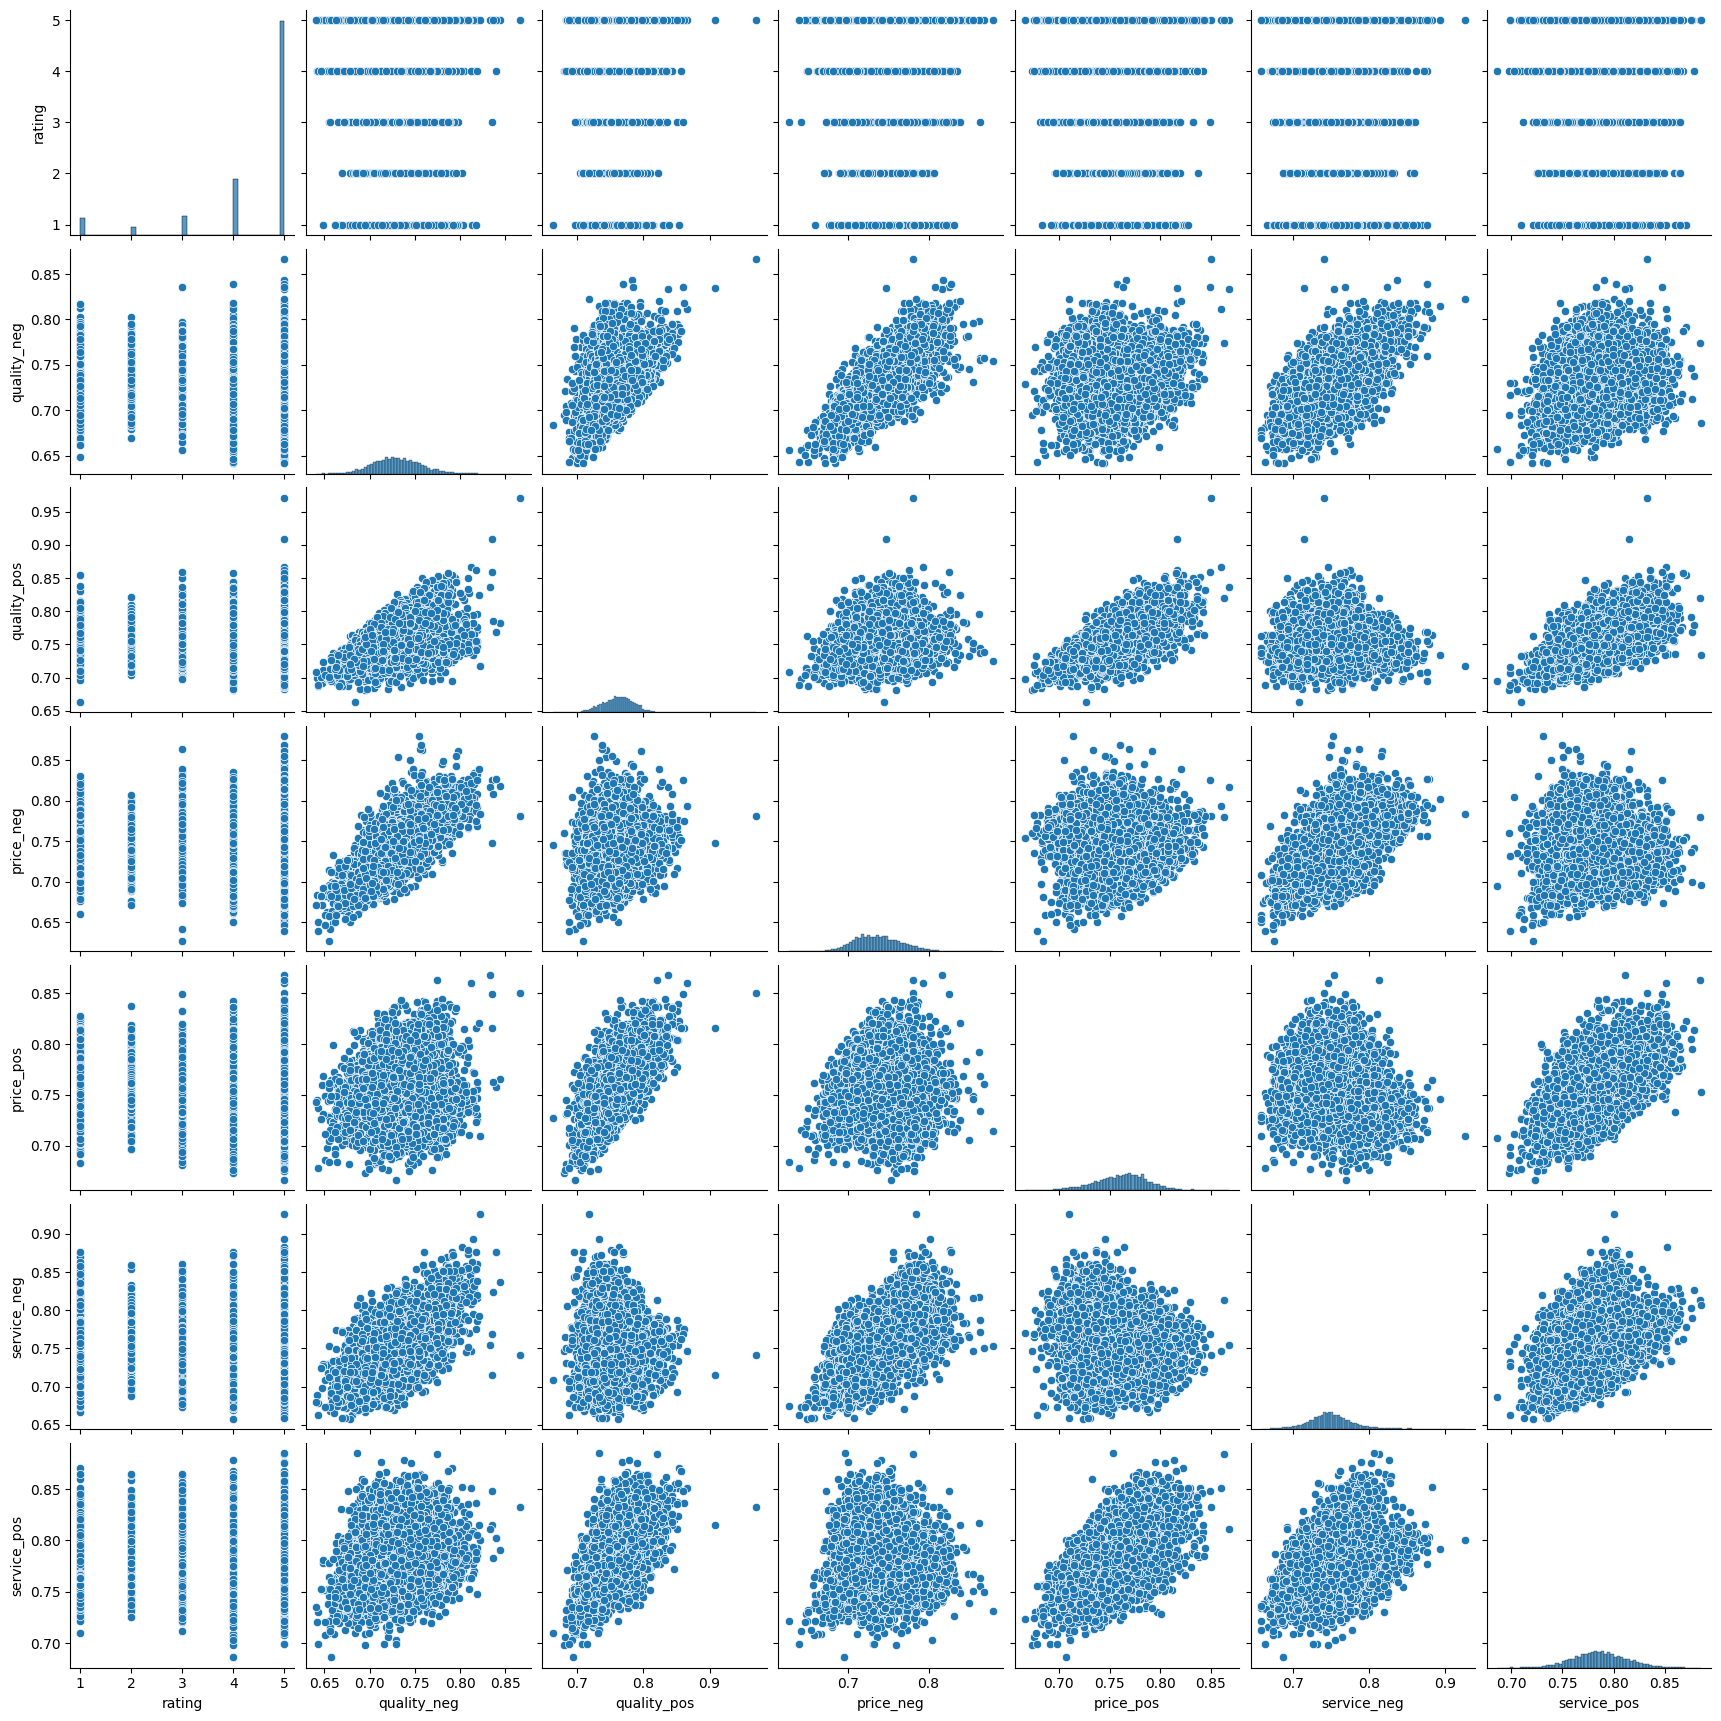

In [21]:
sns.pairplot(df_train[['rating', 'quality_neg', 'quality_pos', 'price_neg', 'price_pos', 'service_neg', 'service_pos']])